# Testing out numerical solver code

## current setup
implicit - explicit solver with an implicit multigrid solver for the diffusion term and RK45 for the reaction term.

## Objectives 

## Model considerations 
* Species
    1. Cell density (sender and pulse cells)
    1. Nutrient density 
    1. mScarlet
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Constitutive fluorescence
        * Basal protein expression 
        * initial protein concentration set to fixed point of max nutrient
    1. Dilution and degradation 
        * Assume that all proteins are degradation tagged
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xs : Expression rate of protein. 


### Model equations
Species:
* $c_p$ : Propagator cells
* $c_s$ : Sender cells
* $n$ : Nutrient
* $a$ : AHL (cell-cell signaling molecule)
* $s$ : Synthase (protein that creates AHL)
* $r$ : Transcriptional repressor (halts production of synthase)

Parameters
* $h_i$ : Hill coefficient
* $k_i$ : Hill function IC50 concentration
* $r_i$ : Species production rate
* $p_i$ : Species degradation or consumption rate
* $D_i$ : Species diffusion coefficient

Inducer-dependent protein production approximation:

$ H(a, n, k) = \frac{a^n}{k^n + a^n}$

$ H_n(a, n, k) = 1 - H(a,n,k) $

Differential equations

$ \partial_t c_p = D_c \Delta c_p + r_c H(n,h_n,90)\,c_p $

$ \partial_t c_s = D_c \Delta c_p + r_c H(n,h_n,90)\,c_s $

$ \partial_t n = D_n \Delta n - p_n H(n,h_n,90)\,(c_p + c_s) $

$ \partial_t a = D_a \Delta a + r_a\,s\,(c_p+c_s)-p_a\,a $

Where $c_s>0$

$ \partial_t s = D_c \Delta s  + (r_s\,c_s - r_c\,s)\,H(n,h_n,90) - p_s\,s$

Where $c_p>0$

$ \partial_t s = D_c \Delta s  + (r_s\,c_p\, H(a,h_s,k_s) H_n(r,h_C,k_C) - r_c\,s)\,H(n,h_n,90) - p_s\,s$

Where both $c_p=0$ and $c_s=0$

$ \partial_t s = D_c \Delta s - p_p\,s$

Where $c_p>0$

$ \partial_t r = D_c \Delta r  + (r_r\,c_p\, H(a,h_r,k_r) - r_c\,r)\,H(n,h_n,90) - p_r\,r$

Where both $c_p=0$ 

$ \partial_t r = D_c \Delta r - p_r\,r$


Inducer-dependent protein production approximation:

$ H(a, n, k) = \frac{a^n}{k^n + a^n}$

Differential equations

$ \partial_t c = D_c \Delta c + r_c H(n,h_n,90)\,c $

$ \partial_t n = D_n \Delta n - k_n H(n,h_n,90)\,c $


In [1]:
# imports
from __future__ import division, print_function

import itertools as itt
import time

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")

import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/home/jparkin/anaconda3/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

# %load_ext memory_profiler
# %load_ext line_profiler
import timeit

from IPython.display import HTML

%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

In [2]:
cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(6)
def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,3, figsize=(10,7))
    axs = axs.flatten()
    im_list = [0,0,0,0,0,0]
    
    # Plot cell densities
    ax_ind = 0
    ax = axs[ax_ind]
    indxs = [cp_i, cs_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[ax_ind] = im
    
    # Plot nutrient densities
    ax_ind = 1
    ax = axs[ax_ind]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[ax_ind] = im
    
    # Plot pulser synthase densities
    ax_ind = 2
    ax = axs[ax_ind]
    indxs = [s_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    indxs = [s_i, cs_i]
    v_arr += im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[ax_ind] = im
    
    # Plot ahl conc
    ax_ind = 3
    ax = axs[ax_ind]
    indxs = [a_i]
    v_arr = im_arr[:,indxs,:,:]
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('ahl')
    im_list[ax_ind] = im
    
    # Plot pulser repressor densities
    ax_ind = 4
    ax = axs[ax_ind]
    indxs = [r_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('repr')
    im_list[ax_ind] = im
    
    # Plot total cellular protein
    ax_ind = 5
    ax = axs[ax_ind]
    indxs = [s_i, r_i]
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cellular protein')
    im_list[5] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [cp_i, cs_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        indxs = [s_i, cs_i]
        frame_arr += im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)
        
        # Plot ahl
        ax = axs[3]
        indxs = [a_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot repr
        ax = axs[4]
        indxs = [cp_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[4].set_array(frame_arr)

        # Plot cellular protein
        ax = axs[5]
        indxs = [s_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[5].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
#     fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


def prep_initial_condition(cs_spots, cp_spots, ahl_spots, dims, p0, A):
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    species, n_h, n_w = dims
    
    cs_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cs_spots:
        cs_cells += disk(cs_cells, np.array(center), scale_s)*od
        
    cp_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cp_spots:
        cp_cells += disk(cp_cells, np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, np.array(center), scale_s)*2.5e3
    
    # Set initial conditions
    for ind, cell_arr in zip([cs_i, cp_i], [cs_cells, cp_cells]):
        A[ind,:,:] += cell_arr
#         A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[a_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A



# Try to find out why solvers quit with too_small_step error

In [3]:
import importlib
from omnisim import split_omnisim as oms
oms = importlib.reload(oms)

In [4]:
# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,    rc,       rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([5e-8,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, (1.6e-2), 
# Da,   xa,    xs,  xS,
2e-4, (1e-7), 250, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.02], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 0.01

simmer = oms.Simulator(16)
scale = simmer.scale
species = simmer.dims[0]
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [5]:
1/(Da*6*scale**2)

3.255208333333333

In [5]:
def exp_fn(arr, slope):
    out_arr = np.exp(-slope*ndi.morphology.distance_transform_bf(arr==0))
    return out_arr

def new_init_conditions(simmer, n_cp=500, n_cs=3):
    simmer.basedims = np.array([4,4])
    simmer.set_scale(simmer.scale)
    simmer.t_eval = np.linspace(0,11*60*60,200)
    ns, nh, nw = simmer.initial_array.shape
    simmer.initial_array = np.zeros_like(simmer.initial_array)
    simmer.initial_array[n_i,:,:] = 100
    odval = 1e-3*scale**2/4
    r_vec = np.linspace(1e-3,0.7,1000)*simmer.scale
    r_probs = r_vec / np.sum(r_vec)
    for i in range(n_cp):
        rad = np.random.choice(r_vec,1,p=r_probs)
        theta = np.random.uniform(0,2*np.pi,size=(1,))
        x = np.int(nw/2 + np.cos(theta)*rad)
        y = np.int(nh/2 + np.sin(theta)*rad)
        simmer.initial_array[cp_i,y,x] += odval
    for i in range(n_cs):
        rad = np.random.choice(r_vec,1,p=r_probs)
        theta = np.random.uniform(0,2*np.pi,size=(1,))
        x = np.int(nw/2 + np.cos(theta)*rad)
        y = np.int(nh/2 + np.sin(theta)*rad)
        simmer.initial_array[cs_i,y,x] = odval
        simmer.initial_array[cp_i,y,x] = 0
#     yslice = slice(0,np.int(nh//2))
#     xslice = slice(np.int(nw//2),np.int(4+nw//2))
#     simmer.initial_array[s_i,yslice,xslice] = (simmer.initial_array[cp_i,yslice,xslice]>0)*1e5
#     xslice = slice(np.int(nw//2-4),np.int(nw//2))
#     simmer.initial_array[r_i,yslice,xslice] = (simmer.initial_array[cp_i,yslice,xslice]>0)*1e5
    # Apply exponential slope. progression rate should be 
    simmer.atol.shape = simmer.initial_array.shape
#     for c_i in [cp_i, cs_i]:
#         arr = simmer.initial_array[c_i,:,:]
#         simmer.initial_array[c_i,:,:] = (scale**2)*(exp_fn(arr, (scale)*rc*400))/2e3
#         simmer.atol[c_i,...] = 1e-
#     simmer.atol.shape = np.prod(simmer.atol.shape)


In [6]:
new_init_conditions(simmer,n_cp=100)

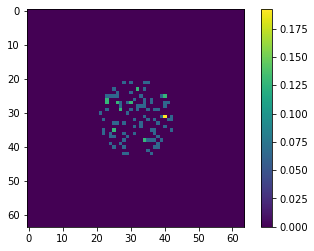

In [7]:
simmer.initial_array.shape = simmer.dims[:-1]
initial_array = simmer.initial_array.copy()
simmer.set_p0(p0)
plt.imshow(simmer.initial_array[[cp_i,cs_i],...].sum(axis=0),interpolation='none')
plt.colorbar()

In [8]:
# simmer.set_p0(p0)

from omnisim.solvers import cn_gmres_2d_lineardiff as cn_gmres
cn_gmres = importlib.reload(cn_gmres)
# impexp = cn_gmres_2d.CNMGRK(simmer, 0, 2*60, first_step=5, rk_step=5e-2)

In [27]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
# xs = 0
# Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
p0=np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])
od0 = 0.01

simmer.set_p0(p0)
for loop_i in [0]:#np.arange(8,10):
    ns, nh, nw, _ = simmer.dims
    ys = []
    ts = []
    for dt in [3]:#[5,2,1,0.5,0.1]:
#         new_init_conditions(simmer)
#         simmer.set_p0(p0)
#         simmer.initial_array = initial_array.copy()
        impexp = cn_gmres.CNMGRK(simmer, 0, 2*60, first_step=dt, rk_step=dt/4)
        n_loops = np.int(8*3600/dt)
        rtime = time.time()
        for i in np.arange(n_loops):
            status, msg = impexp._step_impl()
            if status==False:
                print(msg)
                break
            if (i%20)==0:
                ys.append(impexp.y.copy())
                ts.append(i*dt)
            if (i%1000)==0:
                print("iteration:{} dt:{}".format(i,dt))
                print(dt*i/(time.time() - rtime))

        rtime = time.time() - rtime
    species, nh, nw, dx = simmer.dims
    ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]
    ys_stack = np.concatenate(ys_reshaped,axis=0)
#     skimage.io.imsave('./worker_outputs/smallpads_sa_it{:0d}.tif'.format(loop_i),ys_stack,plugin='tifffile')
#     np.save('./worker_outputs/smallpads_sa_it{:0d}_tvc.npy'.format(loop_i), np.array(ts))
#     print('./worker_outputs/smallpads_it{:0d}.tif'.format(loop_i))
    

iteration:0 dt:3
0.0
iteration:1000 dt:3
267.1298449918504
iteration:2000 dt:3
269.2745903022014
iteration:3000 dt:3
271.6556392493236
iteration:4000 dt:3
272.13904488400243
iteration:5000 dt:3
271.79869038556353
iteration:6000 dt:3
272.07687484992476
iteration:7000 dt:3
272.2567719821209
iteration:8000 dt:3
272.4554091425891
iteration:9000 dt:3
272.34120032642505


In [ ]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()

sim_tmpl = './worker_outputs/smallpads_{}_it{:0d}.tif'
tvc_tmpl = './worker_outputs/smallpads_{}_it{:0d}_tvc.npy'
dt = 3
for loop_i in np.arange(10):
    ns, nh, nw, _ = simmer.dims
    xs_vars = (('sa',250),('sr',0))
    new_init_conditions(simmer, n_cp=100, n_cs=1)
    for csnr, xs in xs_vars:
        ys = []
        ts = []
        p0=np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])
        simmer.set_p0(p0)
        impexp = cn_gmres.CNMGRK(simmer, 0, 2*60, first_step=dt, rk_step=dt/4)
        n_loops = np.int(12*3600/dt)
        rtime = time.time()
        for i in np.arange(n_loops):
            status, msg = impexp._step_impl()
            if status==False:
                print(msg)
                break
            if i%20:
                pass
            else:
                ys.append(impexp.y.copy())
                ts.append(i*dt)
            if i%1000:
                pass
            else:
                print("completion:{:0.2f} dt:{}, loop:{}, cnsr:{}".format(i/n_loops,dt,loop_i,csnr))
                print(dt*i/(time.time() - rtime))
        rtime = time.time() - rtime
        print("runtime:{:0.3f} minutes".format(rtime/60))
        species, nh, nw, dx = simmer.dims
        ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]
        ys_stack = np.concatenate(ys_reshaped,axis=0)
        out_fn = sim_tmpl.format(csnr, loop_i)
        skimage.io.imsave(out_fn,ys_stack,plugin='tifffile')
        out_fn = tvc_tmpl.format(csnr, loop_i)
        np.save(out_fn, np.array(ts))
        print(out_fn)
    

completion:0.00 dt:3, loop:0, cnsr:sa
0.0
completion:0.07 dt:3, loop:0, cnsr:sa
303.31976560688497
completion:0.14 dt:3, loop:0, cnsr:sa
321.5447667526877
completion:0.21 dt:3, loop:0, cnsr:sa
325.40040632363724
completion:0.28 dt:3, loop:0, cnsr:sa
326.73881777393177
completion:0.35 dt:3, loop:0, cnsr:sa
326.96489032014284
completion:0.42 dt:3, loop:0, cnsr:sa
327.9291678120863
completion:0.49 dt:3, loop:0, cnsr:sa
328.013728342516
completion:0.56 dt:3, loop:0, cnsr:sa
328.7314322909145
completion:0.62 dt:3, loop:0, cnsr:sa
329.2947132052762
completion:0.69 dt:3, loop:0, cnsr:sa
329.33613795433735
completion:0.76 dt:3, loop:0, cnsr:sa
329.239557274468
completion:0.83 dt:3, loop:0, cnsr:sa
329.15475042973793
completion:0.90 dt:3, loop:0, cnsr:sa
329.0096120720072
completion:0.97 dt:3, loop:0, cnsr:sa
329.0803673464637
runtime:2.188 minutes
./worker_outputs/smallpads_sa_it0_tvc.npy
completion:0.00 dt:3, loop:0, cnsr:sr
0.0
completion:0.07 dt:3, loop:0, cnsr:sr
313.10253312495183
complet

completion:0.21 dt:3, loop:4, cnsr:sr
314.08538136617057
completion:0.28 dt:3, loop:4, cnsr:sr
314.7812619233258
completion:0.35 dt:3, loop:4, cnsr:sr
315.44400903635704
completion:0.42 dt:3, loop:4, cnsr:sr
316.1118299581299
completion:0.49 dt:3, loop:4, cnsr:sr
316.5069024669223
completion:0.56 dt:3, loop:4, cnsr:sr
316.86655740070404
completion:0.62 dt:3, loop:4, cnsr:sr
317.1872866966609
completion:0.69 dt:3, loop:4, cnsr:sr
317.2985844261246
completion:0.76 dt:3, loop:4, cnsr:sr
317.49836778391614
completion:0.83 dt:3, loop:4, cnsr:sr
318.0496927368583
completion:0.90 dt:3, loop:4, cnsr:sr
318.50710511472727
completion:0.97 dt:3, loop:4, cnsr:sr
318.87819487663916
runtime:2.257 minutes
./worker_outputs/smallpads_sr_it4_tvc.npy
completion:0.00 dt:3, loop:5, cnsr:sa
0.0
completion:0.07 dt:3, loop:5, cnsr:sa
311.1672302485448
completion:0.14 dt:3, loop:5, cnsr:sa
312.6179841144332
completion:0.21 dt:3, loop:5, cnsr:sa
317.0550397590254
completion:0.28 dt:3, loop:5, cnsr:sa
320.987451

completion:0.42 dt:3, loop:9, cnsr:sa
135.78985758715615
completion:0.49 dt:3, loop:9, cnsr:sa
143.55871292364662
completion:0.56 dt:3, loop:9, cnsr:sa
150.42720165551177
completion:0.62 dt:3, loop:9, cnsr:sa
153.6906407480461
completion:0.69 dt:3, loop:9, cnsr:sa
152.21791374245154
completion:0.76 dt:3, loop:9, cnsr:sa
150.45414216646355
completion:0.83 dt:3, loop:9, cnsr:sa
149.73756398427216
completion:0.90 dt:3, loop:9, cnsr:sa
149.06454642792474
completion:0.97 dt:3, loop:9, cnsr:sa
148.36056816874233
runtime:4.876 minutes
./worker_outputs/smallpads_sa_it9_tvc.npy
completion:0.00 dt:3, loop:9, cnsr:sr
0.0


In [ ]:
def exp_fn(arr, slope):
    out_arr = np.exp(-slope*ndi.morphology.distance_transform_bf(arr==0))
    return out_arr

def new_init_conditions(simmer, n_cp=500, n_cs=3):
    simmer.basedims = np.array([12,12])
    simmer.set_scale(simmer.scale)
    simmer.t_eval = np.linspace(0,11*60*60,200)
    ns, nh, nw = simmer.initial_array.shape
    simmer.initial_array = np.zeros_like(simmer.initial_array)
    simmer.initial_array[n_i,:,:] = 100
    odval = 1e-3*scale**2/4
    r_vec = np.linspace(1e-3,2,1000)*simmer.scale
    r_probs = r_vec / np.sum(r_vec)
    for i in range(n_cp):
        rad = np.random.choice(r_vec,1,p=r_probs)
        theta = np.random.uniform(0,2*np.pi,size=(1,))
        x = np.int(nw/2 + np.cos(theta)*rad)
        y = np.int(nh/2 + np.sin(theta)*rad)
        simmer.initial_array[cp_i,y,x] += odval
    for i in range(n_cs):
        rad = np.random.choice(r_vec,1,p=r_probs)
        theta = np.random.uniform(0,2*np.pi,size=(1,))
        x = np.int(nw/2 + np.cos(theta)*rad)
        y = np.int(nh/2 + np.sin(theta)*rad)
        simmer.initial_array[cs_i,y,x] = odval
        simmer.initial_array[cp_i,y,x] = 0
#     yslice = slice(0,np.int(nh//2))
#     xslice = slice(np.int(nw//2),np.int(4+nw//2))
#     simmer.initial_array[s_i,yslice,xslice] = (simmer.initial_array[cp_i,yslice,xslice]>0)*1e5
#     xslice = slice(np.int(nw//2-4),np.int(nw//2))
#     simmer.initial_array[r_i,yslice,xslice] = (simmer.initial_array[cp_i,yslice,xslice]>0)*1e5
    # Apply exponential slope. progression rate should be 
    simmer.atol.shape = simmer.initial_array.shape
#     for c_i in [cp_i, cs_i]:
#         arr = simmer.initial_array[c_i,:,:]
#         simmer.initial_array[c_i,:,:] = (scale**2)*(exp_fn(arr, (scale)*rc*400))/2e3
#         simmer.atol[c_i,...] = 1e-
#     simmer.atol.shape = np.prod(simmer.atol.shape)


In [ ]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()

sim_tmpl = './worker_outputs/medpads_{}_it{:0d}.tif'
tvc_tmpl = './worker_outputs/medpads_{}_it{:0d}_tvc.npy'
dt = 3
for loop_i in np.arange(10):
    ns, nh, nw, _ = simmer.dims
    xs_vars = (('sa',250),('sr',0))
    new_init_conditions(simmer, n_cp=500, n_cs=3)
    for csnr, xs in xs_vars:
        ys = []
        ts = []
        p0=np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])
        simmer.set_p0(p0)
        impexp = cn_gmres.CNMGRK(simmer, 0, 2*60, first_step=dt, rk_step=dt/4)
        n_loops = np.int(12*3600/dt)
        rtime = time.time()
        for i in np.arange(n_loops):
            status, msg = impexp._step_impl()
            if status==False:
                print(msg)
                break
            if i%20:
                pass
            else:
                ys.append(impexp.y.copy())
                ts.append(i*dt)
            if i%1000:
                pass
            else:
                print("completion:{:0.2f} dt:{}, loop:{}, cnsr:{}".format(i/n_loops,dt,loop_i,csnr))
                print(dt*i/(time.time() - rtime))
        rtime = time.time() - rtime
        print("runtime:{:0.3f} minutes".format(rtime/60))
        species, nh, nw, dx = simmer.dims
        ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]
        ys_stack = np.concatenate(ys_reshaped,axis=0)
        out_fn = sim_tmpl.format(csnr, loop_i)
        skimage.io.imsave(out_fn,ys_stack,plugin='tifffile')
        out_fn = tvc_tmpl.format(csnr, loop_i)
        np.save(out_fn, np.array(ts))
        print(out_fn)
    

In [28]:
species, nh, nw, dx = simmer.dims
ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]

In [29]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [30]:
movie_obj = write_movie(ys_stack, np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

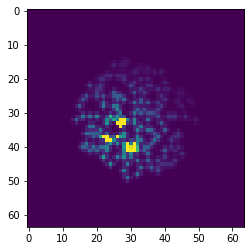

In [31]:
plt.imshow(ys_stack[200,[cp_i,s_i],...].prod(axis=0),vmax=1e5)

In [36]:
movie_obj = write_movie(sr_stack, np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

In [103]:
# sa_ystack = sa_img.copy()
# sr_ystack = sr_img.copy()

In [29]:
img = sr_stack.copy()
nt, ns, nh, nw = img.shape
img_out = np.zeros((nt,3,nh,nw))
for ci, prod_pairs in [(0,(cs_i,s_i)),(1,(cp_i,r_i)),(2,(cp_i,s_i))]:
    img_out[:,ci,...] = img[:,prod_pairs,...].prod(axis=1)
sr_img = img_out

img = sa_stack.copy()
nt, ns, nh, nw = img.shape
img_out = np.zeros((nt,3,nh,nw))
for ci, prod_pairs in [(0,(cs_i,s_i)),(1,(cp_i,r_i)),(2,(cp_i,s_i))]:
    img_out[:,ci,...] = img[:,prod_pairs,...].prod(axis=1)
sa_img = img_out

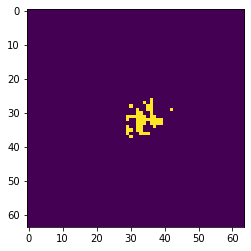

In [64]:
fi=240
plt.imshow((img[fi,ci,:,:]*bool_arr[fi,ci,:,:])>2e3)

(0.0, 20000.0)

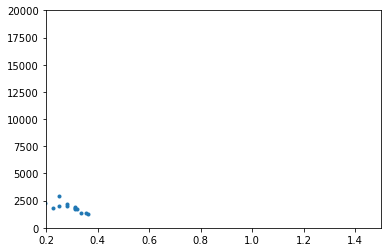

In [34]:
fi=200
plt.plot((dist_arr*bool_arr[fi,ci,:,:]).flatten(),(img[fi,ci,:,:]*bool_arr[fi,ci,:,:]).flatten(),'.')
plt.xlim([0.2,1.5])
plt.ylim([0,2e4])

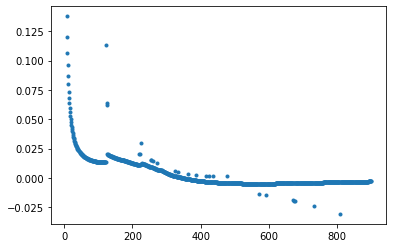

In [90]:
tmp_df = chan_df.groupby(['frame','channel']).agg(np.sum)
sub_df = tmp_df.loc[(slice(None),0),:].reset_index()
plt.plot(sub_df['frame'].values[:-1],np.diff(sub_df['fluor'])/sub_df['fluor'].values[:-1],'.')
# plt.xlim([0,1])

In [100]:
sa_img.shape

(900, 6, 64, 64)

In [30]:
thresh_dict = dict(zip([0,1,2],[2e4,1e4,1e4]))
chan_df_list = []

img = sa_img.copy()
bool_arr = np.zeros_like(img)
for ci in np.arange(3):
    thresh = thresh_dict[ci]
    bool_arr[:,ci,:,:] = img[:,ci,:,:]>thresh
    frame_df_list = []
    for fi in np.arange(img.shape[0]):
        if np.any(bool_arr[fi,0,:,:]) and ci>0:
            dist_arr = ndi.morphology.distance_transform_bf(bool_arr[fi,0,:,:]==False)/scale
            fluor = (img[fi,ci,:,:]*bool_arr[fi,ci,:,:]).flatten()
            dist  = (dist_arr*bool_arr[fi,ci,:,:]).flatten()
            df = pd.DataFrame(dict(zip(['fluor','dist'],[fluor,dist])))
            df.loc[:,'frame'] = fi*np.ones(len(dist))
            frame_df_list.append(df)
        elif np.any(bool_arr[fi,0,:,:]):
            dist_arr = ndi.morphology.distance_transform_bf(bool_arr[fi,0,:,:])/scale
            fluor = (img[fi,ci,:,:]*bool_arr[fi,ci,:,:]).flatten()
            dist  = (dist_arr*bool_arr[fi,ci,:,:]).flatten()
            df = pd.DataFrame(dict(zip(['fluor','dist'],[fluor,dist])))
            df.loc[:,'frame'] = fi*np.ones(len(dist))
            frame_df_list.append(df)
    frame_df = pd.concat(frame_df_list, ignore_index=True)
#     frame_df = frame_df.groupby('frame').agg(np.max).reset_index()
    frame_df.loc[:,'channel'] = ci
    chan_df_list.append(frame_df)
sa_chan_df = pd.concat(chan_df_list, ignore_index=True)

img = sr_img.copy()
bool_arr = np.zeros_like(img)
chan_df_list = []
for ci in np.arange(3):
    thresh = thresh_dict[ci]
    bool_arr[:,ci,:,:] = img[:,ci,:,:]>thresh
    frame_df_list = []
    for fi in np.arange(img.shape[0]):
        if np.any(bool_arr[fi,0,:,:]) and ci>0:
            dist_arr = ndi.morphology.distance_transform_bf(bool_arr[fi,0,:,:]==False)/scale
            fluor = (img[fi,ci,:,:]*bool_arr[fi,ci,:,:]).flatten()
            dist  = (dist_arr*bool_arr[fi,ci,:,:]).flatten()
            df = pd.DataFrame(dict(zip(['fluor','dist'],[fluor,dist])))
            df.loc[:,'frame'] = fi*np.ones(len(dist))
            frame_df_list.append(df)
        elif np.any(bool_arr[fi,0,:,:]):
            dist_arr = ndi.morphology.distance_transform_bf(bool_arr[fi,0,:,:])/scale
            fluor = (img[fi,ci,:,:]*bool_arr[fi,ci,:,:]).flatten()
            dist  = (dist_arr*bool_arr[fi,ci,:,:]).flatten()
            df = pd.DataFrame(dict(zip(['fluor','dist'],[fluor,dist])))
            df.loc[:,'frame'] = fi*np.ones(len(dist))
            frame_df_list.append(df)
    frame_df = pd.concat(frame_df_list, ignore_index=True)
#     frame_df = frame_df.groupby('frame').agg(np.max).reset_index()
    frame_df.loc[:,'channel'] = ci
    chan_df_list.append(frame_df)
sr_chan_df = pd.concat(chan_df_list, ignore_index=True)
# frame = 400

# frame_arr = img[frame,:,:,2]
# plt.imshow(frame_arr>thresh)

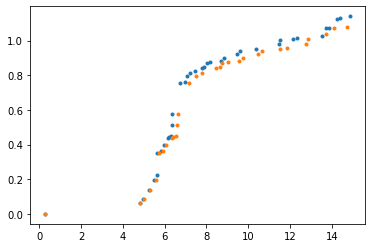

In [31]:
out_df = sa_chan_df.groupby(['frame','channel']).agg(np.max).reset_index()
out_df = out_df.groupby(['dist','channel']).agg(np.min).reset_index()
out_df = out_df.loc[out_df.channel==1,:]
plt.plot(out_df['frame']*3*20/3600,out_df['dist'],'.')
out_df = sr_chan_df.groupby(['frame','channel']).agg(np.max).reset_index()
out_df = out_df.groupby(['dist','channel']).agg(np.min).reset_index()
out_df = out_df.loc[out_df.channel==1,:]
plt.plot(out_df['frame']*3*20/3600,out_df['dist'],'.')

In [92]:
# Define parameter values to sample
xs = 0
# Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
p0=np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])
od0 = 0.01

simmer.set_p0(p0)
# simmer = oms.Simulator(16)
# scale = simmer.scale
# species = simmer.dims[0]
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [ ]:
new_init_conditions(simmer)

In [ ]:
simmer.initial_array.shape = simmer.dims[:-1]
initial_array = simmer.initial_array.copy()
plt.imshow(simmer.initial_array[cp_i,...]-0*simmer.initial_array[cs_i,...],interpolation='none')
plt.colorbar()

In [32]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
for loop_i in np.arange(10):
    ns, nh, nw, _ = simmer.dims
    ys = []
    ts = []
    for dt in [3]:#[5,2,1,0.5,0.1]:
        new_init_conditions(simmer)
        simmer.set_p0(p0)
#         simmer.initial_array = initial_array.copy()
        impexp = cn_gmres_2d.CNMGRK(simmer, 0, 2*60, first_step=dt, rk_step=dt/4)
        n_loops = np.int(15*3600/dt)
        rtime = time.time()
        for i in np.arange(n_loops):
            status, msg = impexp._step_impl()
            if status==False:
                print(msg)
                break
            if i%20:
                continue
            else:
                ys.append(impexp.y.copy())
                ts.append(i*dt)
            if i%1000:
                continue
            else:
                print("iteration:{} dt:{}".format(i,dt))
                print(dt*i/(time.time() - rtime))

        rtime = time.time() - rtime
    #     err_arr = impexp.y
    #     err_arr = err_arr.reshape((species,nh,nw))
    #     for i in np.arange(species):
    #         plt.figure()
    #         plt.imshow(err_arr[i,:,:])
    #         plt.title((dt, i, rtime))
    #     b = cnmg.cn_rhsb_wrxn(x)
    # #     cnmg.w_cycle(x,b,0)
    #     out = splinalg.gmres(A, b, x)
    # #     x = out[0]
    #     if np.mod(i,n_loops/10)==0:
    #         x = impexp.y.copy()
    #         print(i)
    #         print(impexp.cnmg_solver.dt)
    #         x.shape = (ns,nh,nw)
    #         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
    #         x.shape = ns*nh*nw
    species, nh, nw, dx = simmer.dims
    ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]
    ys_stack = np.concatenate(ys_reshaped,axis=0)
    skimage.io.imsave('./worker_outputs/smallpads_sr_it{:0d}.tif'.format(loop_i),ys_stack,plugin='tifffile')
    np.save('./worker_outputs/smallpads_sr_it{:0d}_tvc.npy'.format(loop_i), np.array(ts))
    print('./worker_outputs/smallpads_sr_it{:0d}.tif'.format(loop_i))

iteration:0 dt:3
0.0
iteration:1000 dt:3
137.03860072100474
iteration:2000 dt:3
138.43188091681338
iteration:3000 dt:3
138.32525374428036
iteration:4000 dt:3
132.9302583911637
iteration:5000 dt:3
126.11803952874305
iteration:6000 dt:3
121.89005181148075
iteration:7000 dt:3
121.51243350275553
iteration:8000 dt:3
121.5066607327425
iteration:9000 dt:3
121.80836867195791
iteration:10000 dt:3
121.87511751858673
iteration:11000 dt:3
121.60208045462798
iteration:12000 dt:3
121.00617487138176
iteration:13000 dt:3
120.56824243452316
iteration:14000 dt:3
120.11250639053738
iteration:15000 dt:3
119.76538080503401
iteration:16000 dt:3
119.56443437597429
iteration:17000 dt:3
119.35310977826374
./worker_outputs/smallpads_sr_it0.tif
iteration:0 dt:3
0.0
iteration:1000 dt:3
132.4506177738751
iteration:2000 dt:3
133.44610985404495
iteration:3000 dt:3
132.46791050420958
iteration:4000 dt:3
131.87444397176208
iteration:5000 dt:3
133.32847980224278
iteration:6000 dt:3
134.2333331917465
iteration:7000 dt:3

In [ ]:
species, nh, nw, dx = simmer.dims
ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]

In [ ]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [ ]:
ys_stack = skimage.io.imread('worker_outputs/smallpads_sa_it8.tif')
movie_obj = write_movie(ys_stack, np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

In [ ]:
ys_stack = skimage.io.imread('worker_outputs/smallpads_sa_it0.tif')
movie_obj = write_movie(ys_stack, np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

In [4]:
import skimage.io
# img = skimage.io.imread('worker_outputs/smallpads_coincidence_wi0_it1.tif')
# img.shape

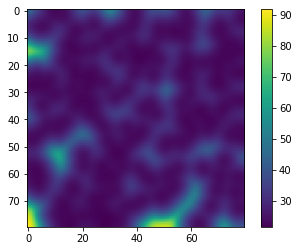

In [53]:
cr_i, csa_i, csb_i, cpa_i, cpb_i, n_i, aa_i, ab_i, sa_i, sb_i, ra_i, rb_i = np.arange(12)
_ = plt.imshow(img[-1,n_i,...])
plt.colorbar()

In [54]:
def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(6)
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,3, figsize=(10,7))
    axs = axs.flatten()
    im_list = [0,0,0,0,0,0]
    
    # Plot cell densities
    ax_ind = 0
    ax = axs[ax_ind]
    indxs = [cp_i, cs_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[ax_ind] = im
    
    # Plot nutrient densities
    ax_ind = 1
    ax = axs[ax_ind]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[ax_ind] = im
    
    # Plot pulser synthase densities
    ax_ind = 2
    ax = axs[ax_ind]
    indxs = [s_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    indxs = [s_i, cs_i]
    v_arr += im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[ax_ind] = im
    
    # Plot ahl conc
    ax_ind = 3
    ax = axs[ax_ind]
    indxs = [a_i]
    v_arr = im_arr[:,indxs,:,:]
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('ahl')
    im_list[ax_ind] = im
    
    # Plot pulser repressor densities
    ax_ind = 4
    ax = axs[ax_ind]
    indxs = [r_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('repr')
    im_list[ax_ind] = im
    
    # Plot total cellular protein
    ax_ind = 5
    ax = axs[ax_ind]
    indxs = [s_i, r_i]
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cellular protein')
    im_list[5] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [cp_i, cs_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        indxs = [s_i, cs_i]
        frame_arr += im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)
        
        # Plot ahl
        ax = axs[3]
        indxs = [a_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot repr
        ax = axs[4]
        indxs = [cp_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[4].set_array(frame_arr)

        # Plot cellular protein
        ax = axs[5]
        indxs = [s_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[5].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
#     fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


def prep_initial_condition(cs_spots, cp_spots, ahl_spots, dims, p0, A):
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    species, n_h, n_w = dims
    
    cs_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cs_spots:
        cs_cells += disk(cs_cells, np.array(center), scale_s)*od
        
    cp_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cp_spots:
        cp_cells += disk(cp_cells, np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, np.array(center), scale_s)*2.5e3
    
    # Set initial conditions
    for ind, cell_arr in zip([cs_i, cp_i], [cs_cells, cp_cells]):
        A[ind,:,:] += cell_arr
#         A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[a_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A



In [55]:
anim = write_movie(img[:,[csa_i,cpa_i,n_i,aa_i,sa_i,ra_i],...],np.arange(img.shape[0]))
HTML(anim.to_html5_video())

In [22]:
anim = write_movie(img[:,[csb_i,cpb_i,n_i,ab_i,sb_i,rb_i],...],np.arange(img.shape[0]))
HTML(anim.to_html5_video())

In [23]:
img = skimage.io.imread('worker_outputs/smallpads_sa_it1.tif')
anim = write_movie(img,np.arange(img.shape[0]))
HTML(anim.to_html5_video())

In [38]:
img = skimage.io.imread('worker_outputs/smallpads_sr_it3.tif')
anim = write_movie(img,np.arange(img.shape[0]))
HTML(anim.to_html5_video())

In [89]:
import skimage.io
img1 = skimage.io.imread('worker_outputs/smallpads_sa_it2.tif')
img2 = skimage.io.imread('worker_outputs/smallpads_sr_it2.tif')

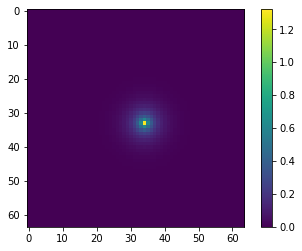

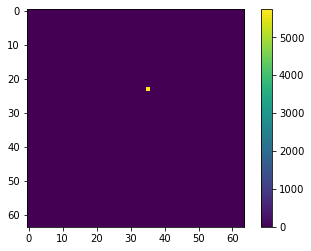

In [93]:
plt.imshow(img1[10,[a_i],...].prod(axis=0))
plt.colorbar()
plt.figure()
plt.imshow(img2[10,[cs_i,s_i],...].prod(axis=0))
plt.colorbar()

In [61]:
fn_tmpl = 'worker_outputs/smallpads_{}_it{}.tif'
out_tmpl = 'worker_outputs/smallpads_tiffstack_{}_{}.tif'
for cn_type in ['sa','sr']:
    for i in np.arange(10):
        fn = fn_tmpl.format(cn_type, i)
        out_fn = out_tmpl.format(cn_type, i)
        img = skimage.io.imread(fn)
        nt, ns, nh, nw = img.shape
        img_out = np.zeros((nt,3,nh,nw))
        for ci, prod_pairs in [(0,(cs_i,s_i)),(1,(cp_i,r_i)),(2,(cp_i,s_i))]:
            img_out[:,ci,...] = img[:,prod_pairs,...].prod(axis=1)
        skimage.io.imsave(out_fn, img_out)

In [62]:
out_tmpl = 'worker_outputs/smallpads_tiffstack_{}_{}.tif'
out_fn = out_tmpl.format('sa','2')
img = skimage.io.imread(out_fn)

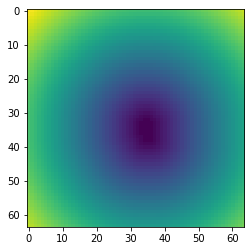

In [21]:
plt.imshow(ndi.morphology.distance_transform_bf(bool_arr[fi,...,0]==False))

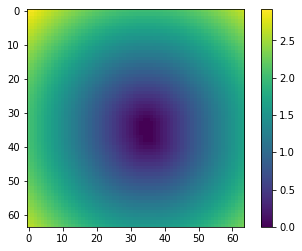

In [27]:
plt.imshow(ndi.morphology.distance_transform_bf(bool_arr[fi,...,0]==False)/scale)
plt.colorbar()

In [74]:
df = pd.DataFrame(dict(zip(['fluor','dist'],[fluor,dist])))
df.loc[:,'frame'] = frame*np.ones(len(dist))


ValueError: operands could not be broadcast together with shapes (3686400,) (4096,) 

In [5]:
plt.imshow(img)

NameError: name 'img' is not defined

In [213]:
out_tmpl = 'worker_outputs/smallpads_tiffstack_{}_{}.tif'
df_list = []
thresh_dict = dict(zip([0,1,2],[1e4,5600,1150]))
for csnr in ['sa','sr']:
    rep_df_list = []
    for rep in np.arange(10):
        out_fn = out_tmpl.format(csnr,rep)
        img = skimage.io.imread(out_fn)
        chan_df_list = []
        bool_arr = np.zeros_like(img)
        for ci in np.arange(3):
            thresh = thresh_dict[ci]
            bool_arr[:,:,:,ci] = img[:,:,:,ci]>thresh
            frame_df_list = []
            for fi in np.arange(img.shape[0]):
                if np.any(bool_arr[fi,:,:,0]) and ci>0:
                    dist_arr = ndi.morphology.distance_transform_bf(bool_arr[fi,:,:,0]==False)/scale
                    fluor = (img[fi,:,:,ci]*bool_arr[fi,:,:,ci]).flatten()
                    dist  = (dist_arr*bool_arr[fi,:,:,ci]).flatten()
                    df = pd.DataFrame(dict(zip(['fluor','dist'],[fluor,dist])))
                    df.loc[:,'frame'] = fi*np.ones(len(dist))
                    frame_df_list.append(df)
                elif np.any(bool_arr[fi,:,:,0]):
                    dist_arr = ndi.morphology.distance_transform_bf(bool_arr[fi,:,:,0])/scale
                    fluor = (img[fi,:,:,ci]*bool_arr[fi,:,:,ci]).flatten()
                    dist  = (dist_arr*bool_arr[fi,:,:,ci]).flatten()
                    df = pd.DataFrame(dict(zip(['fluor','dist'],[fluor,dist])))
                    df.loc[:,'frame'] = fi*np.ones(len(dist))
                    frame_df_list.append(df)
            frame_df = pd.concat(frame_df_list, ignore_index=True)
            frame_df = frame_df.groupby('dist').agg(np.min).reset_index()
            frame_df.loc[:,'channel'] = ci
            chan_df_list.append(frame_df)
        chan_df = pd.concat(chan_df_list, ignore_index=True)
        chan_df.loc[:,'rep'] = rep*np.ones(len(chan_df))
        rep_df_list.append(chan_df)
    rep_df = pd.concat(rep_df_list, ignore_index=True)
    rep_df.loc[:,'consortium'] = csnr
    df_list.append(rep_df)
out_df = pd.concat(df_list, ignore_index=True)
# frame = 400

# frame_arr = img[frame,:,:,2]
# plt.imshow(frame_arr>thresh)

In [100]:
fit_df = out_df[['channel','consortium','rep','dist','frame']].groupby(['channel','consortium','rep','dist']).agg(np.min).reset_index()
# fit_df = fit_df[['channel','consortium','rep','dist','frame']].groupby(['channel','consortium','rep','dist']).agg(np.min).reset_index()

In [101]:
gb_exp = fit_df.groupby(['consortium','rep'])

In [102]:
keys = list(gb_exp.groups.keys())

In [156]:
sub_df = gb_exp.get_group(keys[7]).groupby('channel').get_group(1).reset_index()

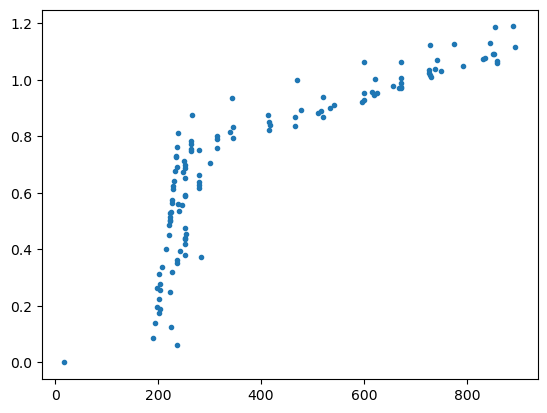

In [157]:
plt.plot(sub_df['frame'], sub_df['dist'],'.')

In [150]:
out_df.loc[out_df.channel==0,:]

,dist,fluor,frame,channel,rep,consortium
0,0.000000,0.000000,18.0,0,0.0,sa
1,0.062500,10002.543523,18.0,0,0.0,sa
2,0.088388,24536.871029,150.0,0,0.0,sa
3,0.125000,78152.520367,270.0,0,0.0,sa
285,0.000000,0.000000,18.0,0,1.0,sa
...,...,...,...,...,...,...
3695,0.139754,47396.164844,503.0,0,8.0,sr
3851,0.000000,0.000000,18.0,0,9.0,sr
3852,0.062500,10000.878889,18.0,0,9.0,sr
3853,0.088388,18077.744717,149.0,0,9.0,sr


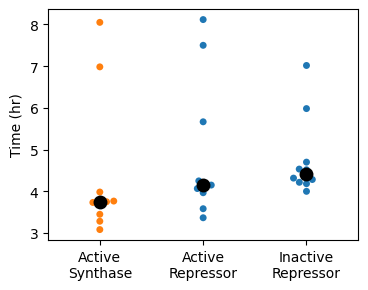

In [291]:
plt.style.use('default')
plt.style.use('fast')
import seaborn as sns
rt_df = out_df.loc[out_df.dist>0.8,:].groupby(['consortium','channel','rep']).agg(np.min)['frame'].reset_index()

rt_df.loc[:,'time'] = rt_df['frame']*60/3600
gb_cond = rt_df.groupby(['consortium','channel'])
plot_keys = [('sa',2),('sa',1),('sr',1)]
labels = ['Active\nSynthase','Active\nRepressor','Inactive\nRepressor']
df_list = [gb_cond.get_group(xx).reset_index() for xx in plot_keys]
for ii, sub_df in enumerate(df_list):
    sub_df['x'] = ii

plot_df = pd.concat(df_list)
plot_df['time'] = plot_df['frame']*60/3600


fig, ax = plt.subplots(1,1,figsize=(4,3))
g = sns.swarmplot(data=plot_df,x='x',y='time',hue='channel',ax=ax)
med_df = gb_cond.agg(np.median)
med_list = [med_df.loc[[xx],:] for xx in plot_keys]
for ii, sub_df in enumerate(med_list):
    sub_df['x'] = ii
med_plot = pd.concat(med_list)
_ = sns.swarmplot(data=med_plot,x='x',y='time',color='black',size=10,ax=ax)
_ = ax.set_xticklabels(labels)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Time (hr)')
ax.legend_.remove()

# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/sim_smallpad_responsetime.png')
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/sim_smallpad_responsetime.pdf')

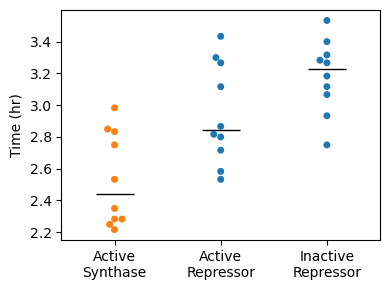

In [346]:
plt.style.use('default')
plt.style.use('fast')
import seaborn as sns
rt_df = out_df.loc[out_df.dist>0.2,:].groupby(['consortium','channel','rep']).agg(np.min)['frame'].reset_index()

rt_df.loc[:,'time'] = rt_df['frame']*60/3600
gb_cond = rt_df.groupby(['consortium','channel'])
plot_keys = [('sa',2),('sa',1),('sr',1)]
labels = ['Active\nSynthase','Active\nRepressor','Inactive\nRepressor']
df_list = [gb_cond.get_group(xx).reset_index() for xx in plot_keys]
for ii, sub_df in enumerate(df_list):
    sub_df['x'] = ii

plot_df = pd.concat(df_list)
plot_df['time'] = plot_df['frame']*60/3600


fig, ax = plt.subplots(1,1,figsize=(4,3))
g = sns.swarmplot(data=plot_df,x='x',y='time',hue='channel',ax=ax)
med_df = gb_cond.agg(np.median)
med_list = [med_df.loc[[xx],:] for xx in plot_keys]
for ii, sub_df in enumerate(med_list):
    sub_df['x'] = ii
med_plot = pd.concat(med_list)
# _ = sns.swarmplot(data=med_plot,x='x',y='time',color='black',size=10,ax=ax)
_ = ax.plot(med_plot['x'],med_plot['time'],color='black',linestyle='none',ms=28,marker='_')
_ = ax.set_xticklabels(labels)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Time (hr)')
ax.legend_.remove()
fig.tight_layout()
fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/sim_smallpad_responsetime.png')
fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/sim_smallpad_responsetime.pdf')

In [292]:
import scipy.signal

In [348]:
import scipy.stats
import scipy.optimize
def f_fun(t,p):
    a, b = p
    l1 = a*t + b
    return l1

def res_fun(p, t, y):
#     a,b,c,d = p
#     if c < 0.5:
#         return -np.inf
    return -1*np.sum(scipy.stats.cauchy.logpdf(f_fun(t,p)-y,scale=0.03))

out_df.loc[:,'time'] = out_df['frame']*60/3600
fit_df = out_df.loc[(out_df.dist>0.2)&(out_df.dist<0.7)&(out_df.channel==1),:].copy()
# fit_df.loc[:,'dist'] = (fit_df['dist'].values//0.05)*0.05
fit_df = fit_df.groupby(['consortium','channel','rep','frame']).agg(np.min).reset_index().sort_values(by='time')
# fit_df = fit_df.groupby(['consortium','channel','rep','dist']).agg(np.max).reset_index()
gb_cond = fit_df.groupby(['consortium','channel','rep'])
slope_list = []
filt_window = 25
for key, sub_df in gb_cond:
    x, y = sub_df['time'],sub_df['dist']
    x = np.array([np.min(x[ii:ii+filt_window]) for ii in np.arange(len(x)-filt_window)])
    y = y[:-filt_window]
    p0 = np.array([0.25,0])
    out = scipy.optimize.minimize(res_fun, p0, args=(x, y))
#     pfit = np.polyfit(x,y,deg=1)
    slope_list.append(out.x[0])

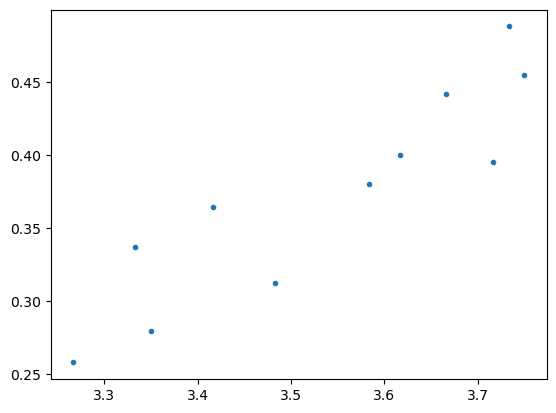

In [349]:
plt.plot(x,y,'.')

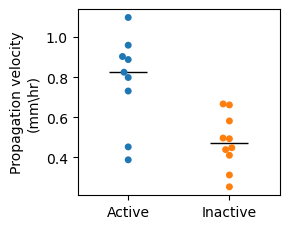

In [350]:
fig, ax = plt.subplots(1,1,figsize=(3,2.4))
labels = ['Active','Inactive']
indx = pd.MultiIndex.from_tuples(gb_cond.groups.keys(),names=['consortium','channel','rep'])
plot_df = pd.DataFrame(index=indx, data={'slope':slope_list}).loc[(slice(None),1,slice(None))]
plot_df = plot_df.loc[plot_df.slope>0,:]
plot_df.loc[('sa',slice(None)),'x'] = 0
plot_df.loc[('sr',slice(None)),'x'] = 1
plot_df = plot_df.reset_index()
g = sns.swarmplot(data=plot_df,x='x',y='slope')

med_df = plot_df.groupby('consortium').agg(np.median)
med_list = [med_df.loc[[xx],:] for xx in ['sa','sr']]
for ii, sub_df in enumerate(med_list):
    sub_df['x'] = ii
med_plot = pd.concat(med_list)
# _ = sns.swarmplot(data=med_plot,x='x',y='slope',color='black',size=8,ax=ax,marker='o',edgecolor='white')
_ = ax.plot(med_plot['x'],med_plot['slope'],color='black',linestyle='none',ms=28,marker='_')
_ = ax.set_xticklabels(labels)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Propagation velocity\n(mm\hr)')
# ax.legend_.remove()
fig.tight_layout()
fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/sim_smallpad_speed.png')
fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/sim_smallpad_speed.pdf')

In [344]:
out_df.loc[:,'time'] = out_df['frame']*60/3600
gb_cond = out_df.loc[(out_df.dist>0.2)&(out_df.dist<0.8),:].groupby(['consortium','channel','rep'])
slope_list = []
for key, sub_df in gb_cond:
    pfit = np.polyfit(sub_df['time'],sub_df['dist'])
    slope_list.append(pfit[0])

plot_keys = [('sa',1),('sr',1)]
labels = ['Active\nSynthase','Active\nRepressor','Inactive\nRepressor']
df_list = [gb_cond.get_group(xx).reset_index() for xx in plot_keys]
for ii, sub_df in enumerate(df_list):
    sub_df['x'] = ii

plot_df = pd.concat(df_list)
plot_df['time'] = plot_df['frame']*60/3600


fig, ax = plt.subplots(1,1,figsize=(4,3))
g = sns.swarmplot(data=plot_df,x='x',y='time',hue='channel',ax=ax)
med_df = gb_cond.agg(np.median)
med_list = [med_df.loc[[xx],:] for xx in plot_keys]
for ii, sub_df in enumerate(med_list):
    sub_df['x'] = ii
med_plot = pd.concat(med_list)
# _ = sns.swarmplot(data=med_plot,x='x',y='time',color='black',size=10,ax=ax)
_ = ax.plot(med_plot['x'],med_plot['time'],color='black',linestyle='none',ms=28,marker='_')
_ = ax.set_xticklabels(labels)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Time (hr)')
ax.legend_.remove()
fig.tight_layout()
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/sim_smallpad_responsetime.png')
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/sim_smallpad_responsetime.pdf')

TypeError: _polyfit_dispatcher() missing 1 required positional argument: 'deg'

In [254]:
img1.shape

(900, 6, 64, 64)

In [ ]:

def _prep_img_arr(img):
    pad_h, pad_w = self.pad_arr.shape[:2]
    self.img_arr[:] = 0
    # Use contrast-stretching approach, where the bounds are the middle 90 percentile
    norm_vec = []
    for chan_ind in np.arange(self.acq.n_chan):
        frame_vals = self.pad_arr[:,:,chan_ind][self.covered_arr].flatten()
        frame_vals = np.sort(np.unique(frame_vals))
        n_vals = len(frame_vals)
        ind_min, ind_max = np.array([0.1*n_vals, 0.95*n_vals-1],dtype=np.int)
        vmin, vmax = frame_vals[ind_min], frame_vals[ind_max]
        vmin = np.max([20,vmin])
        vmax = np.max([vmax+vmin,vmin*2])
        norm_fn = mpl_colors.Normalize(vmin, vmax, clip=True)
        norm_vec.append(norm_fn)
    for chan_ind, chan_slot in enumerate(self.chan_vec):
        norm = norm_vec[chan_ind]
        chan_arr = self.pad_arr[:,:,chan_ind:chan_ind+1]
        color_vec = mpl_colors.to_rgb(mpl_named_colors[chan_slot])
        self.img_arr += np.concatenate([norm(chan_arr)*color_val for color_val in color_vec],axis=2)

def _prep_norm_arr(self):
    norm_fn = mpl_colors.Normalize(0, 1, clip=True)
    self.norm_arr[:,:,:] = (255*norm_fn(self.img_arr)).astype(np.uint8)


In [286]:
plt.plot?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(900, 32, 32, 3)
(900, 32, 32, 3)


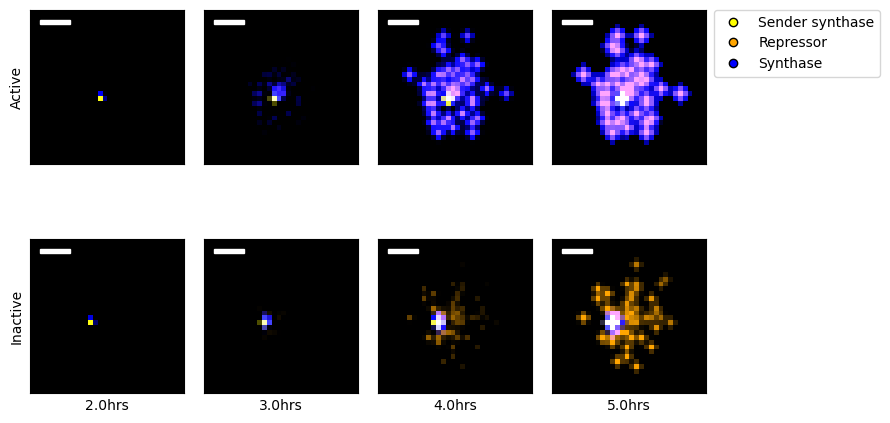

In [290]:
import matplotlib.colors as mpl_colors

from matplotlib import patches

plt.style.use('default')
plt.style.use('fast')
frame_vec = [120,180,240,300]

# get handles for legend
c_names = ['yellow','orange','blue']
labels = ['Sender synthase','Repressor','Synthase']
fig, ax = plt.subplots(1,1)
h_list = []
for c in c_names:
    h = ax.plot(0,0,'o',color=c,mec='black')[0]
    h_list.append(h)
plt.close(fig)
out_tmpl = 'worker_outputs/smallpads_tiffstack_{}_{}.tif'
thresh_dict = dict(zip([0,1,2],[1e4,5600,1150]))
out_fn = out_tmpl.format('sa',3)
img1 = skimage.io.imread(out_fn)[:,scale:-scale,scale:-scale,:]
out_fn = out_tmpl.format('sr',3)
img2 = skimage.io.imread(out_fn)[:,scale:-scale,scale:-scale,:]
nt, nh,nw,ns = img1.shape
img_arr = np.zeros((nh,nw,3))
c_names = ['yellow','orange','blue']
color_arr = np.zeros((nh,nw,3))
fig, axs = plt.subplots(2,4, figsize=(9,5))
for ax_i, img in [(0,img1),(1,img2)]:
    print(img.shape)
    for ax_j, f_i in enumerate(frame_vec):
        ax = axs[ax_i, ax_j]
        img_arr[:] = 0
        for ci, chan in enumerate([0,1,2]):
            color_val = mpl_colors.to_rgb(c_names[ci])
            thresh_val = thresh_dict[ci]
            norm_fn = mpl_colors.Normalize(thresh_val/2,thresh_val*6,clip=True)
            for i in np.arange(3):
                img_arr[:,:,i] += norm_fn(img[f_i,:,:,ci])*color_val[i]
        ax.imshow(img_arr)
        scale_bar = patches.Rectangle((nw/20,nh/20),100/scale,nh/40,
                                      color='w',axes=ax,fill=True,alpha=1,visible=True)
        ax.add_patch(scale_bar)
        ax.set_xticks([])
        ax.set_yticks([])
        if ax_i:
            ax.set_xlabel('{:0.1f}hrs'.format(60*f_i/3600))
axs[0,0].set_ylabel('Active')
axs[1,0].set_ylabel('Inactive')
axs[0,-1].legend(h_list, labels,  bbox_to_anchor=(1.05,1),loc='upper left',borderaxespad=0.)
fig.tight_layout()
fig_tmpl = '/home/jparkin/groupdir/biotek/summary-analysis/figures/stills_smallpad_sims.{}'
# fig_tmpl = os.path.join(acq.super_dir,'figs',fig_tmpl)
for enc in ['png','pdf']:
    fig.savefig(fig_tmpl.format(enc))